# Minimum Snap Trajectory
## Model
* control input $\mathbf u = [u_1, u_2, u_3, u_4]^T$
	* $u_1$ net body force
	* $u_2, u_3, u_4$ body moments according to rotor speeds
* state $\mathbf x = [x, y, z, \phi, \theta, \psi, \dot{x}, \dot{y}, \dot{z}, p, q, r]^T$

## Differential Flatness
* flat outputs $\sigma = [x, y, z , \psi]^T$
	* coordinates of COM $\mathbf r = [x, y, z]^T$
	* yaw angle $\psi$


## Trajectory Optimization
Quadratic Program (QP):
$$
\min\int_{t_o}^{t_m}
\mu_r \left|\left|\frac{d^{k_r}\mathbf{r}_{\text{T}}}{dt^{k_r}}\right|\right| +
\mu_\psi \left|\left|\frac{d^{k_\psi}\psi_{\text{T}}}{dt^{k_\psi}}\right|\right|
dt
$$
s.t.
$$
\begin{aligned}
\sigma_T(t_i)&=\sigma_i ,&\qquad j = 0, \dots, m \\
\left.\frac{d^Px_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_r \\
\left.\frac{d^Py_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_r \\
\left.\frac{d^Pz_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_r \\
\left.\frac{d^P\psi_T}{dt^P}\right|_{t=t_j} &= 0 \text{ or free,} &\qquad  j = 0, \dots, m; p=1, \dots, k_\psi
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re, math

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

from IPython.display import HTML, display

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
from numpy import linspace
from matplotlib.colors import LogNorm
from decimal import *

def deg2rad(deg):
    return deg / 180. * np.pi

keyframes = [
    [0, 0, deg2rad(0)],
    [2, 0, deg2rad(90)],
    [2, 6, deg2rad(180)],
    [0, 6, deg2rad(0)]
]
times = [0, 0.3, 0.7, 1.0]

## Nondimensionalization
Quantities $x_t, y_T, z_T, \psi_T$ are decoupled in cost function and constraints of the QP.
Hence, they can be separated into 4 optimization problems. Considering a general form for a nondimensional variable $\tilde{w}(\tau)$ where $\tau$ represents nondimensionalized time:
$$
\begin{aligned}
\min &\int_0^1 \frac{d^k\tilde{w}(\tau)^2}{d\tau^k}d\tau&\\
\text{s.t.} &\qquad \tilde{w}(\tau_i) = \tilde{w}_i, &\qquad i=0,\dots,m\\
&\qquad \left.\frac{d^P\tilde{w}(\tau)}{d\tilde{w}^P}\right|_{\tau=\tau_j}=0\text{ or free}, &\qquad t_j=0,\dots,1; p=1,\dots,k
\end{aligned}
$$

In [2]:
k = 3 # dimensions
d = 5 # polynomial degree

C = [
    [0, 0, 1],
    [1, 0, 0]
]

times = np.linspace(0, 1, 100)

def polynomial(times, constraints, continuity=2, degree=4):
    pass

### Evaluation for a single, piecewise polynomial

In [3]:
x_s = [0, 0]
x_f = [3, 6]
degree = 2
dimensions = 2
times = np.linspace(0, 1, 100)

C = x_s + x_f
np.linalg.pinv

def time_matrix(t, rows, cols):    
    return np.poly1d([t] * cols)

The $(d+1)\times (c+1)$ time matrix is computed for a specific time $t$ and stores in each column the monomials of the $c_i$-th derivative ($c_i\in[0,c]$) of a $d$ degree polynomial which are evaluated at time $t$.

For example, for degree $d=5$ and continuity $c=3$, we get the following time matrix at time $t=2$:
$$
\begin{pmatrix}
t^5 & 5t^4 & 20t^3 & 60t^2 \\
t^4 & 4t^3 & 12t^2 & 24t   \\
t^3 & 3t^2 & 6t    & 6     \\
t^2 & 2t   & 2     & 0     \\
t^1 & 1    & 0     & 0     \\
t^0 & 0    & 0     & 0 
\end{pmatrix}
=\begin{pmatrix}
32 & 80 & 160 & 240 \\
16 & 32 & 48  & 48  \\
8  & 12 & 12  & 6     \\
4  & 4  & 2   & 0     \\
2  & 1  & 0   & 0     \\
1  & 0  & 0   & 0 
\end{pmatrix}
$$

In [4]:
def time_matrix(time, degree, continuity):
    time_matrix = np.zeros((degree+1, continuity+1))

    poly = np.poly1d([1] * (degree+1))
    for derivation in range(continuity+1):
        time_matrix[:int(len(poly)+1), derivation] = [c*time**d for c, d in zip(poly, range(len(poly),-1,-1))]
        # print "p%s(%i) = %s\n%s" % ("'" * derivation, t, str([c*t**d for c, d in zip(poly, range(len(poly),-1,-1))] + [0]*(continuity-len(poly)-1)), poly)
        poly = np.polyder(poly)

    return time_matrix

Given start and end constraints $\mathbf x_s, \mathbf x_f$, the following method computes the space of polynomials that satisfy these constraints.

Continuity is the number of derivatives that shall be computed per polynomial (one polynomial for each time step).

In [5]:
import scipy
import numpy as np
from scipy import linalg, matrix
# computes the null space of a matrix A
def null_space(A, eps=1e-12):
    u, s, vh = scipy.linalg.svd(A)
    padding = max(0,np.shape(A)[1]-np.shape(s)[0])
    null_mask = np.concatenate(((s <= eps), np.ones((padding,),dtype=bool)),axis=0)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return scipy.transpose(null_space)

In [6]:
def piecewise_min_snap(x_s, x_f, times, degree=4):
    dimensions = x_s.shape[0]
    cperdim = x_s.shape[1]
    continuity = cperdim # or number of columns in a constraint
    
    dd = degree + 1
    cc = continuity + 1

    n_columns = (len(times)-2) * cc + cperdim + cperdim
    n_rows = (len(times)-1) * dd

    print "Columns:", n_columns
    print "Rows:", n_rows
    print "Dimensions:", dimensions
    # knot_intervals = np.diff(times)
    # time_scale = 1 / np.max(knot_intervals)
    # times *= time_scale

    constraints = np.zeros((dimensions, n_columns))
    constraints[:, :cperdim] = x_s
    constraints[:, -cperdim:] = x_f
    print "Constraints:", constraints.shape
    # print constraints

    zero_time_matrix = -time_matrix(0, degree, continuity)
    # print "Zero Time Matrix:\n", zero_time_matrix

    polynomials = np.zeros((n_rows, n_columns))
    print "Polynomials:", polynomials.shape
    polynomials[:dd, :cperdim] = time_matrix(times[0], degree, cperdim-1)
    for i in range(2, len(times)):
        col = (i-2) * cc + cperdim
        row = (i-2) * dd
        polynomials[row:row+dd, col:col+cc] = \
            time_matrix(times[i]-times[i-1], degree, continuity)
        polynomials[row+dd:row+2*dd, col:col+cc] = zero_time_matrix

    polynomials[-dd:, -cperdim:] = \
        time_matrix(times[-1]-times[-2], degree, cperdim-1)

    # print (polynomials[:13, :13])
    # print (polynomials[-13:, -13:])
    solution = (constraints.dot(np.linalg.pinv(polynomials)))
    free = null_space(polynomials.T)
    print "Solution:", solution.shape
    print "Null space:", free.shape

    return solution, free

x_s = np.array([[2, 0, 0], [9, 0, 0]])
x_f = np.array([[5, 0, 0], [2, 0, 0]])
degree = 7
times = np.linspace(0, 1, 8)
solution, free = piecewise_min_snap(x_s, x_f, times, degree)

Columns: 30
Rows: 56
Dimensions: 2
Constraints: (2, 30)
Polynomials: (56, 30)
Solution: (2, 56)
Null space: (56, 26)


26
26
26
26
26


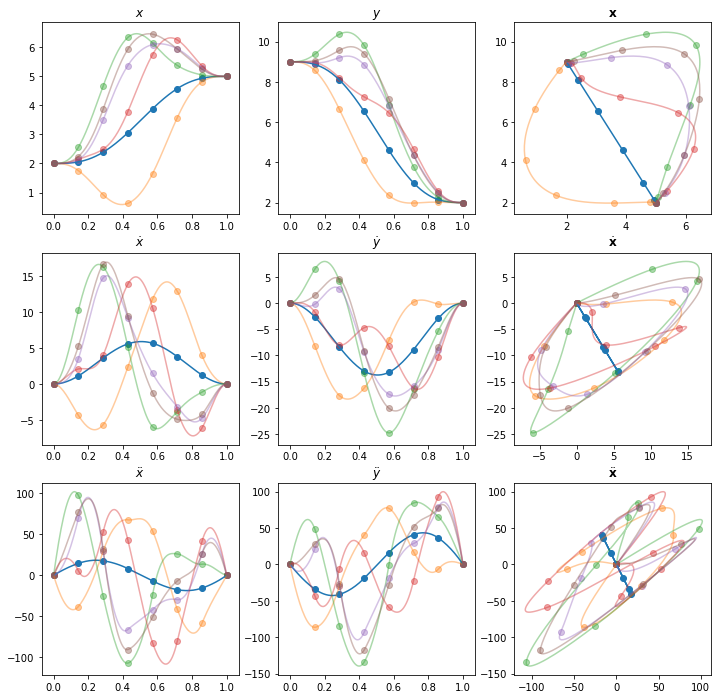

In [7]:
%matplotlib inline
def trajectory_curve(sol, intermediary=20, equal_arc_length=True):
    curve = []
    ts = []
    dots = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        poly = np.poly1d((sol[i, :]))
        if i == 0:
            curve.append(np.polyval(poly, 0))
            ts.append(0)
        step = (t2-t1) / intermediary
        dots.append(np.polyval(poly, 0))
        for j in range(1, intermediary+1):
            curve.append(np.polyval(poly, j*step))
            ts.append(t1 + j*step)
        if i == len(times)-2:
            dots.append(np.polyval(poly, t2-t1))
    return ts, np.array(curve), dots

def trajectory_dots(sol):
    dots = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        dots.append(np.polyval(poly, 0))
        if i == len(times)-2:
            dots.append(np.polyval(poly, t2-t1))
    return dots

def trajectory_curve_derivation(sol, der=1, intermediary=20):
    curve = []
    ts = []
    dots = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        poly = np.poly1d((sol[i, :]))
        poly = np.polyder(poly, m=der)
        if i == 0:
            curve.append(np.polyval(poly, 0))
            ts.append(0)
        step = (t2-t1) / intermediary
        dots.append(np.polyval(poly, 0))
        for j in range(1, intermediary+1):
            curve.append(np.polyval(poly, j*step))
            ts.append(t1 + j*step)
        if i == len(times)-2:
            dots.append(np.polyval(poly, t2-t1))
    return ts, np.array(curve), dots

def trajectory_dots_derivation(sol, der=1, intermediary=20):
    dots = []
    for i, (t1, t2) in enumerate(zip(times, times[1:])):
        poly = np.poly1d((sol[i, :]))
        poly = np.polyder(poly, m=der)
        dots.append(np.polyval(poly, 0))
        if i == len(times)-2:
            dots.append(np.polyval(poly, t2-t1))
    return dots

dd = degree + 1
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 12))
ax1.set_title("$x$")
ax2.set_title("$y$")
ax3.set_title("$\\bf x$")
ts, xs, xdots = trajectory_curve(solution[0,:].reshape((-1, dd)))
ax1.plot(ts, xs)
ax1.scatter(times, xdots)
_, ys, ydots = trajectory_curve(solution[1,:].reshape((-1, dd)))
ax2.plot(ts, ys)
ax2.scatter(times, ydots)
ax3.plot(xs, ys)
ax3.scatter(xdots, ydots)
rs = []
for k in range(5):
    print free.shape[1]
    r = 1500 * (np.random.rand(free.shape[1], 1) - 0.5)
    rs.append(r)
    sol = solution + free.dot(r).T
    _, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
    ax1.plot(ts, xs, alpha=0.4)
    ax1.scatter(times, xdots, alpha=0.4)
    _, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
    ax2.plot(ts, ys, alpha=0.4)
    ax2.scatter(times, ydots, alpha=0.4)
    ax3.plot(xs, ys, alpha=0.4)
    ax3.scatter(xdots, ydots, alpha=0.4)
    
ax4.set_title("$\\dot{x}$")
ax5.set_title("$\\dot{y}$")
ax6.set_title("$\\dot{\\bf x}$")
ts, xs, xdots = trajectory_curve_derivation(solution[0,:].reshape((-1, dd)))
ax4.plot(ts, xs)
ax4.scatter(times, xdots)
_, ys, ydots = trajectory_curve_derivation(solution[1,:].reshape((-1, dd)))
ax5.plot(ts, ys)
ax5.scatter(times, ydots)
ax6.plot(xs, ys)
ax6.scatter(xdots, ydots)
for r in rs:
    sol = solution + free.dot(r).T
    _, xs, xdots = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)))
    ax4.plot(ts, xs, alpha=0.4)
    ax4.scatter(times, xdots, alpha=0.4)
    _, ys, ydots = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)))
    ax5.plot(ts, ys, alpha=0.4)
    ax5.scatter(times, ydots, alpha=0.4)
    ax6.plot(xs, ys, alpha=0.4)
    ax6.scatter(xdots, ydots, alpha=0.4)
    
ax7.set_title("$\\ddot{x}$")
ax8.set_title("$\\ddot{y}$")
ax9.set_title("$\\ddot{\\bf x}$")
ts, xs, xdots = trajectory_curve_derivation(solution[0,:].reshape((-1, dd)), der=2)
ax7.plot(ts, xs)
ax7.scatter(times, xdots)
_, ys, ydots = trajectory_curve_derivation(solution[1,:].reshape((-1, dd)), der=2)
ax8.plot(ts, ys)
ax8.scatter(times, ydots)
ax9.plot(xs, ys)
ax9.scatter(xdots, ydots)
for r in rs:
    sol = solution + free.dot(r).T
    _, xs, xdots = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)), der=2)
    ax7.plot(ts, xs, alpha=0.4)
    ax7.scatter(times, xdots, alpha=0.4)
    _, ys, ydots = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)), der=2)
    ax8.plot(ts, ys, alpha=0.4)
    ax8.scatter(times, ydots, alpha=0.4)
    ax9.plot(xs, ys, alpha=0.4)
    ax9.scatter(xdots, ydots, alpha=0.4)

### Total arc length of piecewise polynomial
Polynomials $f_i:[a_i,b_i]\to\mathbb{R}$ for $i=1..m$, where $f$ is a piecewise polynomial $\displaystyle f(t)=\sum_i\mathbb{I}\left[t\in[a_i, b_i]\right] f_i(t)$

Arc length $L(f_i)$ is defined as follows:
$$
L(f) = \sum_i \int_{a_i}^{b_i} \left|f_i'(t)\right| dt
$$

### Sampling equidistant points on piecewise polynomial
Sample $n$ points on $f$ such that $\forall i: L(f(x_{i}))-L(f(x_{i-1})) = \frac{L(f)}{n}$

In [235]:
# generate 2d toy map
voxel_size = 0.1
xmin, xmax = -1, 1
ymin, ymax = -1, 1

obstacle1 = [
    (-1, -1),  # left bottom
    (-.1, -.3) # right top
]

obstacle2 = [
    (-1, .3), # left bottom
    (-.1, 1)  # right top
]

smoothness = 1.9 * voxel_size
certainty = 0.7
prior = 0.5

def generate_voxel_patch(x, y, mean=None, color=None, size=voxel_size):
    return patches.Rectangle(
        xy=(x, y),
        width=size,
        height=size,
        color="black" if color is None else color,
        alpha=1 if mean is None else mean)

def bernoulli_std(p):
    return np.sqrt(p * (1-p))

def distance_point_rect(p, rect_center, rect_dim):
    dx = max(abs(p[0] - rect_center[0]) - rect_dim[0] / 2, 0)
    dy = max(abs(p[1] - rect_center[1]) - rect_dim[1] / 2, 0)
    return np.sqrt(dx ** 2 + dy ** 2)

def estimate_map(x, y):
    if ((obstacle1[0][0] <= x <= obstacle1[1][0]) and (obstacle1[0][1] <= y <= obstacle1[1][1])) or \
        ((obstacle2[0][0] <= x <= obstacle2[1][0]) and (obstacle2[0][1] <= y <= obstacle2[1][1])):
            # obstacle
            mean = prior + certainty * (1 - prior)
#             print mean
            return mean, bernoulli_std(mean)
    else:
        obstacle1_center = np.mean([obstacle1[0], obstacle1[1]], axis=0)
        obstacle1_dim = np.abs(np.array(obstacle1[1]) - np.array(obstacle1[0]))
#         print obstacle1_center
#         print obstacle1_dim
        dist1 = distance_point_rect((x, y), obstacle1_center, obstacle1_dim)
        obstacle2_center = np.mean([obstacle2[0], obstacle2[1]], axis=0)
        obstacle2_dim = np.abs(np.array(obstacle2[1]) - np.array(obstacle2[0]))
        dist2 = distance_point_rect((x, y), obstacle2_center, obstacle2_dim)
#         print dist1 + dist2
        n = prior
        m = -n / smoothness
        truth = max(m * (min(dist1, dist2) - smoothness) + n, 0)
#         print dist1 + dist2, truth
        mean = (truth - prior) * certainty + prior
#         print mean
        return mean, bernoulli_std(mean)

xdim = int((xmax-xmin) / voxel_size + 1)
ydim = int((ymax-ymin) / voxel_size + 1)
world = [[() for i in range(xdim)] for j in range(ydim)]
for i in range(xdim):
    x = xmin + i * voxel_size
    for j in range(ydim):
        y = ymin + j * voxel_size
        world[i][j] = estimate_map(x, y)

def plot_world(ax):
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xticks(np.arange(xmin, xmax, voxel_size))
    ax.set_yticks(np.arange(ymin, ymax, voxel_size))
    ax.grid()

    for i in range(xdim):
        x = xmin + i * voxel_size
        for j in range(ydim):
            y = ymin + j * voxel_size
            ax.add_patch(generate_voxel_patch(x, y, world[i][j][0]))      

Columns: 38
Rows: 72
Dimensions: 2
Constraints: (2, 38)
Polynomials: (72, 38)
Solution: (2, 72)
Null space: (72, 34)
Best UCB: 0.00913861139891
Optimization terminated successfully.
         Current function value: -0.015818
         Iterations: 23
         Function evaluations: 758
  status: 0
    nfev: 758
 success: True
     fun: -0.01581790224448814
       x: array([-138.33538307, -141.90112536,   59.75101391,  -50.7986651 ,
       -114.21303956,   59.83329578,   14.42314883,  136.28465137,
        -98.64752784,   87.14987348,  -74.24382363,   -0.93280932,
          7.61687689,  -81.44908594,  -44.70975234,  142.19622429,
         88.51037896,  -22.75515986,   -6.95844388,  134.10698314,
         46.48813801,    5.4280914 ,  -31.64642362,   72.65485779,
        108.56643812,  -66.81742207,  114.1835035 ,  109.87696202,
         -5.84773289,  -42.30354614,  -73.01030798,   56.73048432,
         47.73120385,   74.5899627 ])
 message: 'Optimization terminated successfully.'
     nit: 

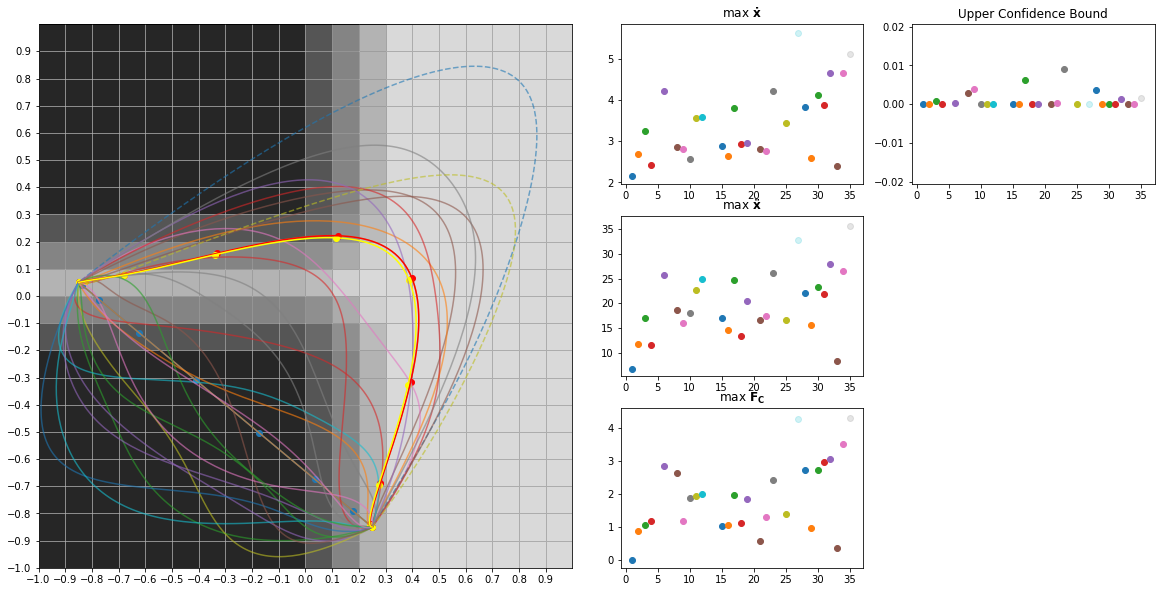

In [236]:
fig = plt.figure(figsize=(20,10))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3, 4)
ax = fig.add_subplot(gs[:3, :2])

ax2 = fig.add_subplot(gs[0, 2])
ax2.set_title("$\\max\ \\bf \\dot{x}$")
ax3 = fig.add_subplot(gs[1, 2])
ax3.set_title("$\\max\ \\bf \\ddot{x}$")
ax4 = fig.add_subplot(gs[2, 2])
ax4.set_title("$\\max\ \\bf F_C$")
ax5 = fig.add_subplot(gs[0, 3])
ax5.set_title("Upper Confidence Bound")

plot_world(ax)

x_s = np.array([[ 0.25, 0, 0], [-0.85, 0, 0]])
x_f = np.array([[-0.85, 0, 0], [ 0.05, 0, 0]])
degree = 7
times = np.linspace(0, 1, 10)

solution, free = piecewise_min_snap(x_s, x_f, times, degree)
ts, xs, xdots = trajectory_curve(solution[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(solution[1,:].reshape((-1, dd)))
ax.plot(xs, ys)
ax.scatter(xdots, ydots, zorder=2)

def evaluate(solution, kappa=-3.2): # todo kappa is NEGATIVE!!
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    # draw occupied voxels
    occupied = set()
    for x, y in zip(xs, ys):
        i = int((x - xmin) / voxel_size)
        j = int((y - ymin) / voxel_size)
        if i < 0 or j < 0 or i >= xdim or j >= ydim:
            return -1000
        occupied.add((i, j))
    
    reach_left, reach_right = Decimal(1), Decimal(1)
    reach = 1.
    for (i, j) in occupied:
#         x = xmin + i * voxel_size
#         y = ymin + j * voxel_size
#         ax.add_patch(generate_voxel_patch(x, y, 0.5, color="orange"))
        
        mean, std = world[i][j]
        var = Decimal(std) ** Decimal(2)
        mean_sq = Decimal(1.-mean) ** Decimal(2)
        reach_left *= var + mean_sq
        reach_right *= mean_sq        
        reach *= 1. - mean
        
    var_reachability = reach_left - reach_right    
    KAPPA = Decimal(kappa)
    ucb = float(Decimal(reach) - var_reachability.sqrt() * KAPPA)
    return ucb
    
MAX_VELOCITY = 5
MAX_ACCELERATION = 30
MAX_FORCE = 3.6

MASS = 0.5 # kg

best_ucb = (evaluate(solution), xs, ys, 100 * (np.random.rand(free.shape[1], 1) - 0.5), xdots, ydots)
for k in range(35):
    r = 300 * (np.random.rand(free.shape[1], 1) - 0.5)
    sol = solution + free.dot(r).T if k > 0 else solution
    _, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
    _, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
    xs, ys = np.array(xs), np.array(ys)
    if any(xs < xmin) or any(ys < ymin) or any(xs > xmax) or any(ys > ymax):
        continue
    ucb = evaluate(sol)
    
    _, xds, _ = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)))
    _, yds, _ = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)))
    max_velocity = max(np.max(np.abs(xds)), np.max(np.abs(yds)))
    _, xdds, _ = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)), der=2)
    _, ydds, _ = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)), der=2)
    max_acceleration = max(np.max(np.abs(xdds)), np.max(np.abs(ydds)))
    
    
    # compute curvature
    # {\displaystyle \kappa ={\frac {|x'y''-y'x''|}{\left(x'^{2}+y'^{2}\right)^{\frac {3}{2}}}},}
    curvature = np.abs(xds*ydds - yds*xdds)/((xds**2 + yds**2)**1.5)
    # compute centripetal force F = curvature * m * v^2
    v = 0.5 * (xds + yds) # is this the right velocity for both dimensions?
    force = curvature * MASS * v ** 2
    max_force = np.max(force)
    
    out_of_bounds = max_velocity > MAX_VELOCITY or max_acceleration > MAX_ACCELERATION or max_force > MAX_FORCE
    
    ax2.scatter([k+1], [max_velocity], alpha=0.2 if out_of_bounds else 1)
    ax3.scatter([k+1], [max_acceleration], alpha=0.2 if out_of_bounds else 1)
    ax4.scatter([k+1], [max_force], alpha=0.2 if out_of_bounds else 1)
    
    if ucb > -1000:
        ax5.scatter([k+1], ucb, alpha=0.2 if out_of_bounds else 1)
    else:
        ax5.scatter([k+1], np.nan)
    if not out_of_bounds and ucb > best_ucb[0]:
        best_ucb = (ucb, xs, ys, r, xdots, ydots)
    ax.plot(xs, ys, alpha=0.6, linestyle="dashed" if out_of_bounds else "solid")

print "Best UCB:", best_ucb[0]
ax.plot(best_ucb[1], best_ucb[2], color="red")
ax.scatter(best_ucb[4], best_ucb[5], color="red", zorder=2)

r = best_ucb[3]
def best_ucb(params):
    sol = solution + free.dot(np.array(params)).T
    ucb = evaluate(sol)
    return -ucb  # maximize, i.e. minimize negative UCB


from scipy.optimize import minimize

# res = minimize(best_ucb, r, method='Powell', options={'xtol': 1e-15, 'ftol': 1e-15, 'disp': True, 'maxiter': 2000, 'maxfev': 2000})
res = minimize(best_ucb, r, method='Nelder-Mead', options={'xtol': 1e-5, 'disp': True, 'maxiter': 500})
# minimizer_kwargs = {"method": "Powell"}
# res = scipy.optimize.basinhopping(best_ucb, r, minimizer_kwargs=minimizer_kwargs, niter=100)

print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

Curvature is computed by ${\displaystyle \kappa ={\frac {\left|x'y''-y'x''\right|}{\left(x'^{2}+y'^{2}\right)^{\frac {3}{2}}}}}$ which is interpreted as $\displaystyle\kappa = \frac{1}{R}$ for radius $R$.

The centripetal force $\bf F_C$ is defined as $\displaystyle{\bf F_C} = \frac{mv^2}{R}$ for mass $m$ and velocity $v$. I assumed $\displaystyle v=\frac{x' + y'}{2}$.

Tunable parameters: 34
Iterations:  1


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: axis=0 is invalid for the 0-dimensional input array

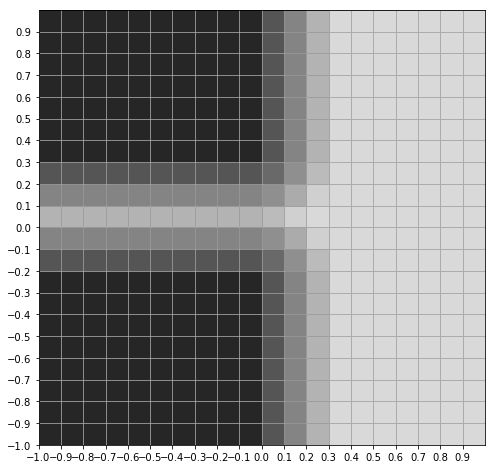

In [58]:
from tqdm import tnrange, tqdm_notebook
from ipywidgets import FloatProgress
from IPython.display import display

fig, ((ax)) = plt.subplots(1, 1, figsize=(8, 8))
plot_world(ax)

choices = 1
per_dimension = np.linspace(-200, 300, choices)
full_choice = np.tile(per_dimension, (free.shape[1], 1))

def valid_trajectory(**kwargs):
    param = kwargs["x_new"]
    sol = solution + free.dot(np.array(param)).T
    
    _, xs, _ = trajectory_curve(sol[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(sol[1,:].reshape((-1, dd)))
    xs, ys = np.array(xs), np.array(ys)
    if any(xs < xmin) or any(ys < ymin) or any(xs > xmax) or any(ys > ymax):
        return False
    
    _, xds, _ = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)))
    _, yds, _ = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)))
    max_velocity = max(np.max(np.abs(xds)), np.max(np.abs(yds)))
    if max_velocity > MAX_VELOCITY:
        return False
    
    _, xdds, _ = trajectory_curve_derivation(sol[0,:].reshape((-1, dd)), der=2)
    _, ydds, _ = trajectory_curve_derivation(sol[1,:].reshape((-1, dd)), der=2)
    max_acceleration = max(np.max(np.abs(xdds)), np.max(np.abs(ydds)))    
    if max_acceleration > MAX_ACCELERATION:
        return False
    
    # compute curvature
    # {\displaystyle \kappa ={\frac {|x'y''-y'x''|}{\left(x'^{2}+y'^{2}\right)^{\frac {3}{2}}}},}
    curvature = np.abs(xds*ydds - yds*xdds)/((xds**2 + yds**2)**1.5)
    # compute centripetal force F = curvature * m * v^2
    v = 0.5 * (xds + yds) # is this the right velocity for both dimensions?
    force = curvature * MASS * v ** 2
    max_force = np.max(force)
    if max_force > MAX_FORCE:
        return False
    
    return True

valid_xs = []
valid_ys = []
iterations = int(choices ** free.shape[1])
print "Tunable parameters:", free.shape[1]
print "Iterations: ", iterations
f = FloatProgress(min=0, max=iterations)
display(f)
#for i in tnrange(iterations):
for i in range(iterations):
    param = []
    index = i
    for d in range(free.shape[1]-1, -1, -1):
        j = int(index / (choices ** d))
        index = index % (choices ** d)
        param.append(per_dimension[j])
#     print i, param
    
    sol = solution + free.dot(np.array(param)).T
    
    if valid_trajectory(x_new=param):
        _, xs, _ = trajectory_curve(sol[0,:].reshape((-1, dd)))
        _, ys, _ = trajectory_curve(sol[1,:].reshape((-1, dd)))
#         ax.plot(xs, ys, alpha=0.3)
        valid_xs.append(xs)
        valid_ys.append(ys)
    
    if i % 100 == 0:
        f.value = i
    
valid_xs = np.array(valid_xs)
valid_ys = np.array(valid_ys)
# ax.fill_between(np.mean(valid_xs, axis=0), np.mean(valid_ys, axis=0) - np.std(valid_ys, axis=0), np.mean(valid_ys, axis=0) + np.std(valid_ys, axis=0), facecolor='yellow', alpha=0.2, edgecolor='none', antialiased=True, zorder=2)
mx, my = np.mean(valid_xs, axis=0), np.mean(valid_ys, axis=0)
sx, sy = np.std(valid_xs, axis=0), np.std(valid_ys, axis=0)
ax.fill(np.concatenate([np.flip(mx - sx, 0), mx + sx]), np.concatenate([np.flip(my - sy, 0), my + sy]), facecolor='yellow', alpha=0.2, edgecolor='none', antialiased=True, zorder=2)
ax.plot(np.max(valid_xs, axis=0), np.max(valid_ys, axis=0), label="max", zorder=2)
ax.plot(np.mean(valid_xs, axis=0), np.mean(valid_ys, axis=0), label="$\\mu$", zorder=2)
ax.plot(np.mean(valid_xs, axis=0) + np.std(valid_xs, axis=0), np.mean(valid_ys, axis=0) + np.std(valid_ys, axis=0), color="yellow", label="$\\mu+\\sigma$", zorder=2)

  status: 2
    nfev: 3026
 success: False
     fun: -2.5209580077683394e-23
       x: array([ -2.07833863e+01,   1.51502947e+02,  -4.77319384e+01,
         4.22540634e+01,  -4.08117761e+00,   1.18858512e+01,
        -5.13238067e-01,  -9.92381749e+00,   1.62899860e-01,
        -1.57669569e+00,  -1.89170456e+01,  -2.36684362e+00,
        -2.20137031e+01,  -4.50832499e+01,   3.74221187e+01,
         5.24008447e+01,  -1.92505159e+00,   1.50996520e+00,
         4.47940190e+00,   2.21305659e+01,   9.58746740e+01,
         4.09951582e+01,   1.65980431e+00,  -4.45335332e+00,
         1.77347215e+01,  -6.02023104e+01,   1.10213955e-01,
        -6.77229412e+01,  -5.96617720e-01,   1.35642108e+01,
         5.32694958e+01,  -3.36968278e+01,  -2.54667821e-01,
         8.48577542e+01])
 message: 'Maximum number of iterations has been exceeded.'
     nit: 2500


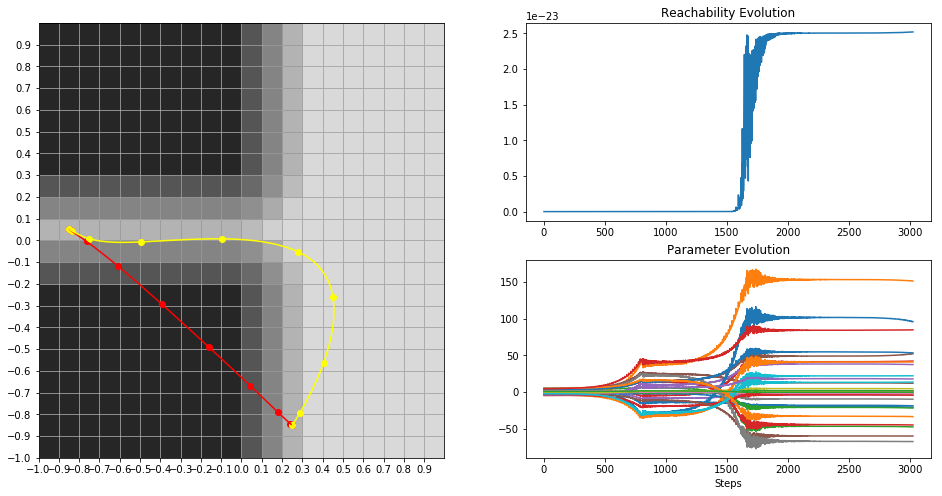

In [10]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

param_evolution = []
reach_evolution = []

def reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    occupied = set()
    for x, y in zip(xs, ys):
        i = int((x - xmin) / voxel_size)
        j = int((y - ymin) / voxel_size)
        if i < 0 or j < 0 or i >= xdim or j >= ydim:
            return -1000
        occupied.add((i, j))
    
    reach = 1.
    for (i, j) in occupied:        
        mean, std = world[i][j]     
        reach *= 1. - mean
        
    reach_evolution.append(reach)
    return reach

def smooth_reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    reach = 1.
    for x, y in zip(xs, ys):       
        mean, std = estimate_map(x, y)    
        reach *= 1. - mean
        
    reach_evolution.append(reach)
    return reach

def best_reachability(param):
    global param_evolution
    param_evolution.append(param)
    sol = solution + free.dot(np.array(param)).T
    return -smooth_reachability(sol)

res = minimize(best_reachability, param, method='Nelder-Mead', options={'xtol': 1e-35, 'disp': True, 'maxiter': 2500})
# minimizer_kwargs = {"method": "Powell"}
# res = scipy.optimize.basinhopping(best_reachability, param, minimizer_kwargs=minimizer_kwargs, niter=100, stepsize=10)

ax2.plot(reach_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

As can be seen, the optimization performance (e.g. using Nelder-Mead) improves significantly, when a continuous map representation is used, since the cost function is not discrete anymore due to changes in voxel occupancy by the trajectory.
Basin Hopping with a larger step size (10) was able to generate good results, even on the discrete map representation. However, this seems to be that way mostly due to the random displacement of the parameters. If the step size of this displacement is not that large anymore, Basin Hopping also fails to escape the grid constraints.

In the real mapping setting, we cannot rely on a smooth mapping function but have to deal with the voxel grid for optimization. In order to still get a smooth sampling of real coordinates in the voxel grid, bilinear filtering can be used as it is a common computer graphics technique to sample from 2d textures.

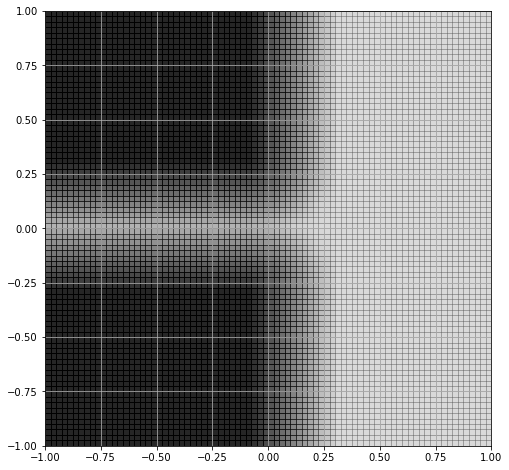

In [11]:
def bilinear_filter(x, y):    
    u = (x - xmin) / voxel_size
    v = (y - ymin) / voxel_size
    x = int(u)
    y = int(v)
    u_ratio = u - x
    v_ratio = v - y
    u_opposite = 1 - u_ratio
    v_opposite = 1 - v_ratio
    x, y = max(min(xdim - 1, x), 0), max(min(ydim - 1, y), 0)
    xp, yp = max(min(xdim - 1, x + 1), 0), max(min(ydim - 1, y + 1), 0) # repeat voxels at edges
    def filter_index(i):
        return (world[x][y][i] * u_opposite + world[xp][y][i] * u_ratio) * v_opposite \
            + (world[x][yp][i] * u_opposite  + world[xp][yp][i] * u_ratio) * v_ratio
    return filter_index(0), filter_index(1)

# plot example smoothed map with much smaller voxels
def plot_smoothed_world(ax, nvoxel_size):
    xdim = int((xmax-xmin) / nvoxel_size + 1)
    ydim = int((ymax-ymin) / nvoxel_size + 1)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
#     ax.set_xticks(np.arange(xmin, xmax, nvoxel_size))
#     ax.set_yticks(np.arange(ymin, ymax, nvoxel_size))
    ax.grid()

    for i in range(xdim):
        x = xmin + i * nvoxel_size
        for j in range(ydim):
            y = ymin + j * nvoxel_size
            ax.add_patch(generate_voxel_patch(x, y, bilinear_filter(x, y)[0], size=nvoxel_size))

fig, ((ax)) = plt.subplots(1, 1, figsize=(8, 8))
nvoxel_size = voxel_size / 4
plot_smoothed_world(ax, nvoxel_size)

## Reachability based on bilinear filtering
### Local Optimization without constraints
Evaluate reachability over $T$ discrete time steps with fixed $\Delta t$
$$
R = \prod_{t=1}^T (1-\hat{m}(\mathbf{x}(t)))
$$

  status: 1
    nfev: 6800
 success: False
     fun: -7.9548918728600838e-23
       x: array([-278.98174555, -143.58135831, -247.25734176,   12.02333355,
        188.10456956,  -21.22508489, -513.87340789,  301.16489713,
       -778.22954774,   -7.28496952,   54.42519788, -173.10849187,
       -869.23880923,   36.84893515, -452.87621565, -402.13446223,
       -671.9739304 , -488.2220577 ,  -41.11445835,  138.28732338,
       -765.72417555,  -65.01501013,  100.71181739,   76.44125019,
        155.68605145, -916.80719911,  134.79689251, -356.86113543,
       -315.19620056,  231.12146827,   21.16389829, -126.17133115,
       -247.83727232,  -57.2332016 ])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 5770


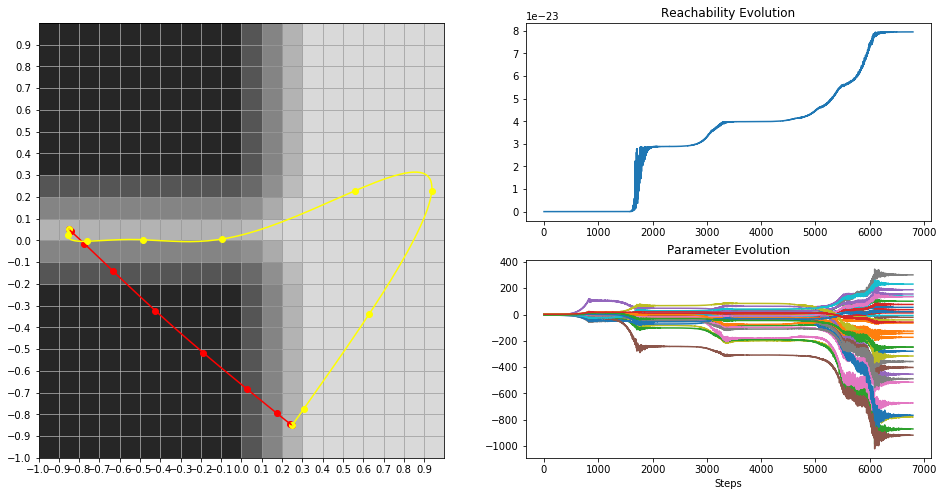

In [12]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

param_evolution = []
reach_evolution = []
def bilinear_reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    reach = 1.
    for x, y in zip(xs, ys):
#         u = (x - xmin) / voxel_size
#         v = (y - ymin) / voxel_size
#         x = int(u)
#         y = int(v)
#         mean, std = world[x][y]
        mean, std = bilinear_filter(x, y)
        reach *= 1. - mean
        
    reach_evolution.append(reach)
    return reach

def best_reachability(param):
    global param_evolution
    param_evolution.append(param)
    sol = solution + free.dot(np.array(param)).T
    return -bilinear_reachability(sol)

res = minimize(best_reachability, param, method='Nelder-Mead', options={'xtol': 1e-25, 'disp': True, 'maxiter': 10000})
# minimizer_kwargs = {"method": "Nelder-Mead"}
# res = scipy.optimize.basinhopping(best_reachability, param, minimizer_kwargs=minimizer_kwargs, niter=10, stepsize=10)

ax2.plot(reach_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

### Local Optimization without constraints, computing Product Integral
$$
R = \prod_{t=1}^T (1-\hat{m}(\mathbf{x}(t)))^{\left|\left|\mathbf{x}(t) - \mathbf{x}(t-1)\right|\right|_2}
$$

  status: 2
    nfev: 5971
 success: False
     fun: -0.59598233295438585
       x: array([  3.49810597e+00,   1.64791729e+01,  -4.26375946e+00,
        -2.51852763e-01,  -1.12119063e+02,  -8.78013556e+00,
         3.92752992e+02,   6.37991708e+01,  -6.84666745e+01,
        -1.12614351e+02,  -5.51370521e+01,  -1.75006335e+01,
         2.16708148e+01,  -9.33709380e+00,  -5.23366702e+00,
        -1.20670723e+02,   3.16835022e+01,   2.18035834e+00,
         4.64764900e+01,   1.61197424e+01,   2.44032325e+01,
        -7.70789008e+01,   2.42097636e+01,   1.64273154e+02,
         3.11617821e+01,  -1.70244669e+02,   1.51694271e+02,
        -8.80432462e+01,   2.11938533e+02,   3.98150954e+00,
         7.36028079e+01,   1.37089223e+01,   8.30752449e+00,
        -3.45452131e+01])
 message: 'Maximum number of iterations has been exceeded.'
     nit: 5000


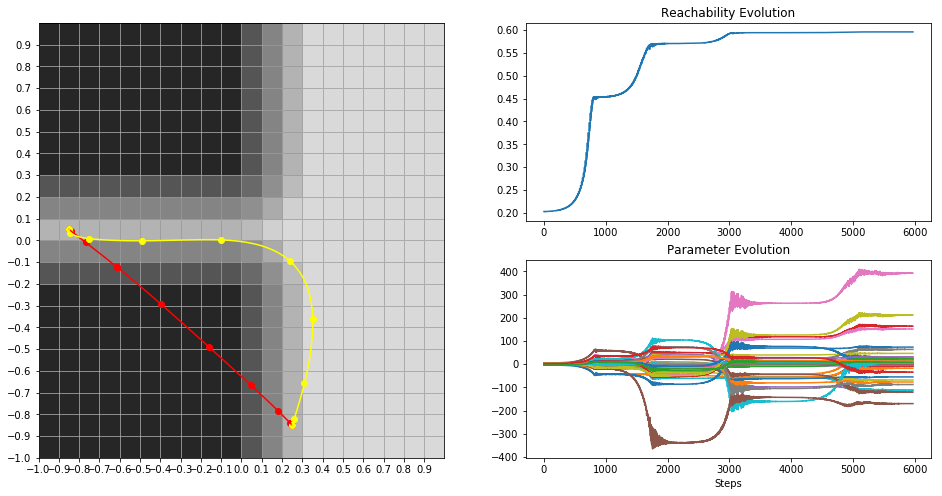

In [62]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

param_evolution = []
reach_evolution = []
def bilinear_reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    reach = 1.
    lx, ly = xs[0], ys[0]
    for x, y in zip(xs, ys):
#         u = (x - xmin) / voxel_size
#         v = (y - ymin) / voxel_size
#         x = int(u)
#         y = int(v)
#         mean, std = world[x][y]
        delta = np.sqrt((x-lx) ** 2 + (y-ly) ** 2)
        mean, std = bilinear_filter(x, y)
        reach *= (1. - mean) ** delta
        lx, ly = x, y
        
    reach_evolution.append(reach)
    return reach

def best_reachability(param):
    global param_evolution
    param_evolution.append(param)
    sol = solution + free.dot(np.array(param)).T
    return -bilinear_reachability(sol)

res = minimize(best_reachability, param, method='Nelder-Mead', options={'xtol': 1e-25, 'disp': True, 'maxiter': 5000})
# minimizer_kwargs = {"method": "Nelder-Mead"}
# res = scipy.optimize.basinhopping(best_reachability, param, minimizer_kwargs=minimizer_kwargs, niter=10)

ax2.plot(reach_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

## Box Sampling

  status: 2
    nfev: 3557
 success: False
     fun: -0.58112937290613353
       x: array([  1.35412534e+01,   7.84471485e+01,  -1.93897826e+01,
         2.42170166e+02,   5.24257664e+01,   3.02710604e+01,
         9.98712589e+01,   2.18908854e+01,   1.29611990e+01,
        -6.83804520e+00,   8.37672988e+01,   1.40606321e+01,
         1.27931549e+01,  -2.98487520e+01,   8.75994412e+01,
         1.56553639e+01,  -8.06689903e+01,   6.47862629e-03,
        -1.89514166e+02,  -9.61887798e+01,  -1.71803966e+02,
         1.08299182e+02,  -2.49856744e+02,   5.78120559e+01,
        -2.34784470e+01,  -3.68430547e+01,   3.79516652e+01,
        -1.47029113e+02,   2.05284608e+01,  -3.19395693e+01,
        -4.96034074e+01,   2.50106364e+01,  -1.70227572e+01,
         5.88628122e+01])
 message: 'Maximum number of iterations has been exceeded.'
     nit: 3000


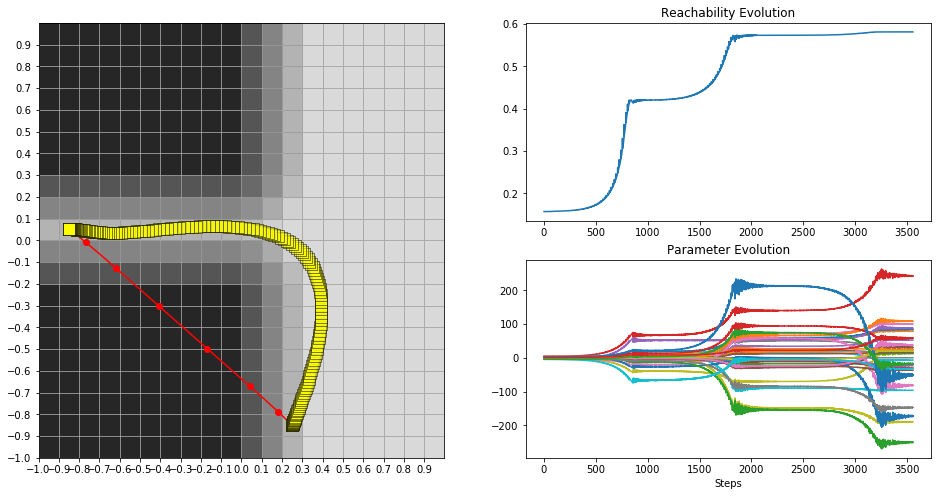

In [161]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

def box_sample(x, y, box_size=0.7*voxel_size):
    l = max(x-box_size/2, xmin)
    r = min(x+box_size/2, xmax)
    b = max(y-box_size/2, ymin)
    t = min(y+box_size/2, ymax)
    li, ri, bi, ti = int((l - xmin) / voxel_size), int((r - xmin) / voxel_size), \
                     int((b - ymin) / voxel_size), int((t - ymin) / voxel_size)
    mh, mv = ri * voxel_size + xmin, ti * voxel_size + ymin
#     print l, mh, r
#     print b, mv, t
    if li == ri and  bi == ti:
#         print "li == ri and bi == ti", li, bi
        return world[li][ti]
    def filter_index(i):
        if bi == ti:
#             print "horizontal", mh-l, r-mh
            return ((mh-l)*box_size*world[li][ti][i] + (r-mh)*box_size*world[ri][ti][i]) / (box_size**2)
        if li == ri:
#             print "vertical", mv-b, t-mv
            return ((mv-b)*box_size*world[li][bi][i] + (t-mv)*box_size*world[li][ti][i]) / (box_size**2)
    
#         print li, ri, bi, ti
        return ( (mv-b)*(mh-l)*world[li][bi][i] + (t-mv)*(mh-l)*world[li][ti][i] \
               + (mv-b)*(r-mh)*world[ri][bi][i] + (t-mv)*(r-mh)*world[ri][ti][i]) / (box_size**2)
    
    return filter_index(0), filter_index(1)

param_evolution = []
reach_evolution = []
def box_reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    reach = 1.
    lx, ly = xs[0], ys[0]
    for x, y in zip(xs, ys):
#         u = (x - xmin) / voxel_size
#         v = (y - ymin) / voxel_size
#         x = int(u)
#         y = int(v)
#         mean, std = world[x][y]
        delta = np.sqrt((x-lx) ** 2 + (y-ly) ** 2)
        mean, std = box_sample(x, y)
        reach *= (1. - mean) ** delta
        lx, ly = x, y
        
    reach_evolution.append(reach)
    return reach

def best_reachability(param):
    global param_evolution
    param_evolution.append(param)
    sol = solution + free.dot(np.array(param)).T
    return -box_reachability(sol)

# x, y = -0.456, 0.1
# print box_sample(x, y)
# print bilinear_filter(x, y)
# return
res = minimize(best_reachability, param, method='Nelder-Mead', options={'xtol': 1e-25, 'disp': True, 'maxiter': 3000})
# minimizer_kwargs = {"method": "Nelder-Mead"}
# res = scipy.optimize.basinhopping(best_reachability, param, minimizer_kwargs=minimizer_kwargs, niter=10)

ax2.plot(reach_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.scatter(xs, ys, c="yellow", zorder=3, s=150, marker="s", edgecolors="black", alpha=0.5)
#ax.scatter(xdots, ydots, color="yellow", zorder=2)

# print "\n".join(["%.1f %.1f - %.2f (bilinear: %.2f)" % (x, y, box_sample(x, y)[0], bilinear_filter(x, y)[0]) for x, y in zip(xs, ys)])

## Circle Sampling

  status: 2
    nfev: 3588
 success: False
     fun: -0.58382554729516889
       x: array([  7.16298226e+00,   3.94172291e+01,  -4.34304118e+02,
        -2.32460238e+01,   1.35737304e+01,  -7.62480428e+01,
        -1.96860865e+01,  -1.80217716e+01,  -3.30958320e+01,
         1.02072761e+02,  -8.66366936e+01,   3.94662434e+00,
         4.41378129e+01,  -4.45924050e+01,  -1.13829038e+02,
        -3.57830705e+01,  -5.04582674e+00,   9.99085994e+00,
         5.46414919e+01,  -7.56071638e+01,   2.01192766e+01,
        -4.18214196e-01,   1.37154482e+01,   1.86535593e+01,
         8.42262189e+01,   2.99224746e+01,   1.15057135e+02,
        -4.71739636e+01,   3.56733912e+01,  -1.56410226e+01,
        -9.06476878e+01,   1.31184972e+02,   2.83026614e+00,
         1.21078649e+02])
 message: 'Maximum number of iterations has been exceeded.'
     nit: 3000


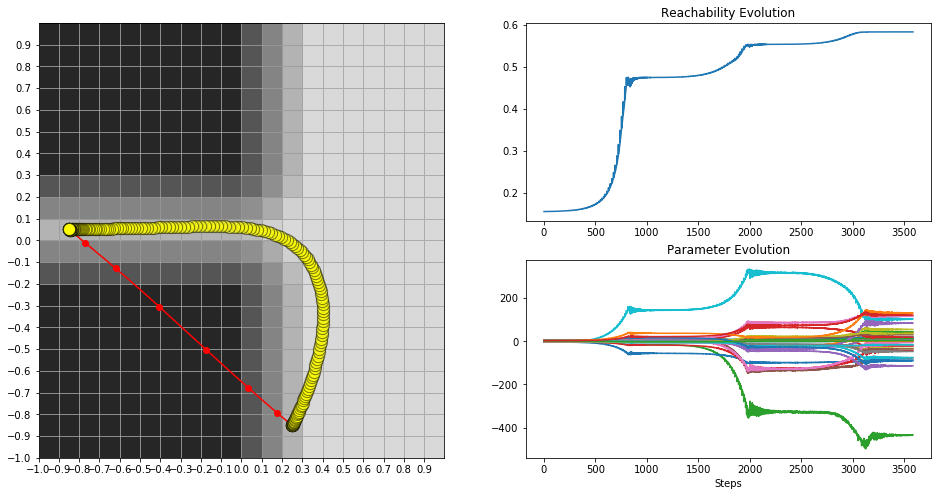

In [237]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

import math

# Area of intersection between circle and rectangle (src: http://stackoverflow.com/a/32698993)

# returns the positive root of intersection of line y = h with circle centered at the origin and radius r
def section(h, r = 1):
    # assume r is positive, leads to some simplifications in the formula below (can factor out r from the square root)
    assert(r >= 0)
    # http://www.wolframalpha.com/input/?i=r+*+sin%28acos%28x+%2F+r%29%29+%3D+h
    return np.sqrt(r ** 2 - h ** 2) if h < r else 0

# indefinite integral of circle segment
def g(x, h, r = 1):
    # http://www.wolframalpha.com/input/?i=r+*+sin%28acos%28x+%2F+r%29%29+-+h
    return .5 * (np.sqrt(1 - x**2 / (r**2)) * x * r + r**2 * math.asin(x / r) - 2 * h * x)

# area of intersection of an infinitely tall box with left edge at x0, right edge at x1, bottom edge at h and top edge at infinity, with circle centered at the origin with radius r
def area4(x0, x1, h, r):
    if x0 > x1:
        # this must be sorted otherwise we get negative area
        x0, x1 = x1, x0
    s = section(h, r)
    # integrate the area
    return g(max(-s, min(s, x1)), h, r) - g(max(-s, min(s, x0)), h, r)

# area of the intersection of a finite box with a circle centered at the origin with radius r
def area_(x0, x1, y0, y1, r):
    if y0 > y1:
        y0, y1 = y1, y0 # this will simplify the reasoning
    if y0 < 0:
        if y1 < 0:
            # the box is completely under, just flip it above and try again
            return area_(x0, x1, -y0, -y1, r)
        else:
            # the box is both above and below, divide it to two boxes and go again
            return area_(x0, x1, 0, -y0, r) + area_(x0, x1, 0, y1, r)
    else:
        # y0 >= 0, which means that y1 >= 0 also (y1 >= y0) because of the swap at the beginning
        assert(y1 >= 0)
        # area of the lower box minus area of the higher box
        return area4(x0, x1, y0, r) - area4(x0, x1, y1, r)

# area of the intersection of a general box with a general circle
def area(x0, x1, y0, y1, cx, cy, r):
    # get rid of the circle center
    x0 -= cx
    x1 -= cx
    y0 -= cy
    y1 -= cy

    return area_(x0, x1, y0, y1, r)

import matplotlib.patches
def circle_sample(x, y, diameter=0.7*voxel_size):
    radius = diameter/2.
    l = max(x-radius, xmin)
    r = min(x+radius, xmax)
    b = max(y-radius, ymin)
    t = min(y+radius, ymax)
    li, ri, bi, ti = int((l - xmin) / voxel_size), int((r - xmin) / voxel_size), \
                     int((b - ymin) / voxel_size), int((t - ymin) / voxel_size)
    mh, mv = ri * voxel_size + xmin, ti * voxel_size + ymin
    
    mh, mv = ri * voxel_size + xmin, ti * voxel_size + ymin
    if li == ri and  bi == ti:
        return world[li][ti]
    circle_area = np.pi * radius**2
    def filter_index(i):
        if bi == ti:
#             print "horizontal", mh-l, r-mh
            return (area(l, mh, b, t, x, y, radius)*world[li][ti][i] + area(mh, r, b, t, x, y, radius)*world[ri][ti][i]) / circle_area
        if li == ri:
#             print "vertical", mv-b, t-mv
            return (area(l, r, b, mv, x, y, radius)*world[li][bi][i] + area(l, r, mv, t, x, y, radius)*world[li][ti][i]) / circle_area
    
#         print li, ri, bi, ti
        return ( area(l, mh, b, mv, x, y, radius)*world[li][bi][i] + area(l, mh, mv, t, x, y, radius)*world[li][ti][i] \
               + area(mh, r, b, mv, x, y, radius)*world[ri][bi][i] + area(mh, r, mv, t, x, y, radius)*world[ri][ti][i]) / circle_area
    return filter_index(0), filter_index(1)

param_evolution = []
reach_evolution = []
def circle_reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    reach = 1.
    lx, ly = xs[0], ys[0]
    for x, y in zip(xs, ys):
#         u = (x - xmin) / voxel_size
#         v = (y - ymin) / voxel_size
#         x = int(u)
#         y = int(v)
#         mean, std = world[x][y]
        delta = np.sqrt((x-lx) ** 2 + (y-ly) ** 2)
        mean, std = circle_sample(x, y)
        reach *= (1. - mean) ** delta
        lx, ly = x, y
        
    reach_evolution.append(reach)
    return reach

def best_reachability(param):
    global param_evolution
    param_evolution.append(param)
    sol = solution + free.dot(np.array(param)).T
    return -circle_reachability(sol)

# x, y = -0.456, 0.1
# print box_sample(x, y)
# print bilinear_filter(x, y)
# return
res = minimize(best_reachability, param, method='Nelder-Mead', options={'xtol': 1e-25, 'disp': True, 'maxiter': 3000})
# minimizer_kwargs = {"method": "Nelder-Mead"}
# res = scipy.optimize.basinhopping(best_reachability, param, minimizer_kwargs=minimizer_kwargs, niter=10)

ax2.plot(reach_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.scatter(xs, ys, c="yellow", zorder=3, s=150, marker="o", edgecolors="black", alpha=0.5)
#ax.scatter(xdots, ydots, color="yellow", zorder=2)

# print "\n".join(["%.1f %.1f - %.2f (bilinear: %.2f)" % (x, y, box_sample(x, y)[0], bilinear_filter(x, y)[0]) for x, y in zip(xs, ys)])

### Local Optimization without constraints, computing Product Integral
$$
R = \prod_{t=1}^T (1-\hat{m}(\mathbf{x}(t)))^{\Delta t}
$$
where $\Delta t$ is constant.

  status: 2
    nfev: 1145
 success: False
     fun: -0.00016811142100652712
       x: array([  6.12388062e+00,   5.67583665e+01,   2.13027738e+00,
        -3.81727447e+00,   8.22413415e+00,  -2.80965907e+00,
        -2.36651141e+01,   1.90244116e+00,  -1.01780376e+01,
        -3.96809301e+00,  -2.83740882e-02,   5.98374243e+01,
        -6.87935538e-01,  -3.70104240e+01,   5.13988355e+00,
         2.18265396e+01,  -3.78984785e+00,  -1.06237989e+01,
         6.18796041e+00,   1.67653639e+01,  -8.24730292e+00,
        -2.70898841e+00,  -2.50430345e+00,   2.70187259e-01,
         2.85321427e+01,   1.45296985e-01,   1.31142096e+00,
         6.30192007e-01,   5.55798474e+00,  -1.24363259e+02,
         2.92202941e+00,  -6.41836780e+00,   5.70000731e+00,
         6.21250392e+00])
 message: 'Maximum number of iterations has been exceeded.'
     nit: 1000


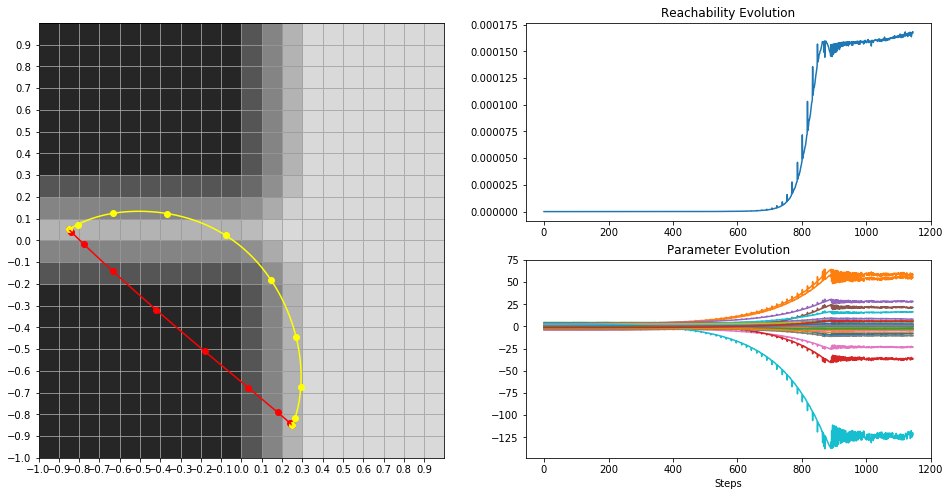

In [50]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

delta_t = np.mean(np.diff(times))

param_evolution = []
reach_evolution = []
def bilinear_reachability_delta_t(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    reach = 1.
    for x, y in zip(xs, ys):
        mean, std = bilinear_filter(x, y)
        reach *= (1. - mean) ** delta_t
        lx, ly = x, y
        
    reach_evolution.append(reach)
    return reach

def best_reachability_deltat(param):
    global param_evolution
    param_evolution.append(param)
    sol = solution + free.dot(np.array(param)).T
    return -bilinear_reachability_delta_t(sol)

res = minimize(best_reachability_deltat, param, method='Nelder-Mead', options={'xtol': 1e-25, 'disp': True, 'maxiter': 1000})
# minimizer_kwargs = {"method": "Nelder-Mead"}
# res = scipy.optimize.basinhopping(best_reachability_deltat, param, minimizer_kwargs=minimizer_kwargs, niter=10, stepsize=10, accept_test=valid_trajectory)

ax2.plot(reach_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

## Reachability without bilinear filtering
### Reachability based on arc length that traverses voxel
For every voxel $v_i$ on trajectory $\mathbf{x}$
$$
R = \prod_i \left(1-m(v_i)\right)^{\displaystyle \mathfrak{L}(\mathbf{x}[v_i])}
$$
The local optimizer cannot handle the discontinuity of this reachability function.

  status: 1
    nfev: 6800
 success: False
     fun: -0.34061232123041557
       x: array([ 0.8095333 ,  0.17715506, -1.58620079,  6.77974913, -2.08299541,
       -2.17084178,  1.18268589,  5.71099958, -0.56513155, -0.37564496,
        2.53280283,  0.19257331,  6.97280318, -3.93057648, -0.41460359,
        1.25493017,  1.38032398, -0.50276314, -5.83963026, -6.34750947,
        1.79949516,  3.94789581, -3.41602124,  4.12175274, -0.05779486,
       -0.66738219, -8.09062564, -4.06856452,  1.04782026, -3.88152778,
       -1.65699302, -6.08836085,  0.72878229, -0.80216129])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 4790


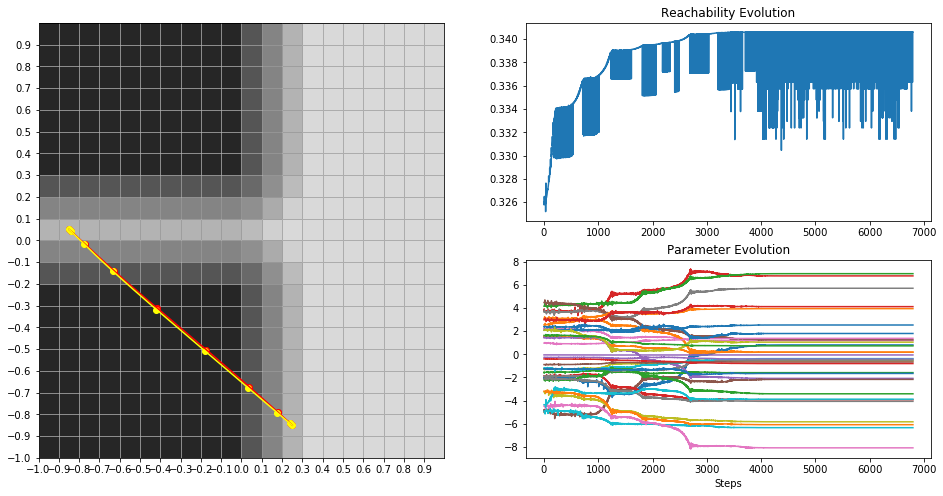

In [63]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

param_evolution = []
reach_evolution = []
def voxelarc_reachability(solution):
    global reach_evolution
    
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    reach = 0
    total_arc_length = 0.
    for x0, y0, x1, y1 in zip(xs, ys, xs[1:], ys[1:]):
        arc_length = np.sqrt((x1-x0)**2 + (y1-y0)**2)

        t0, t1 = x0, x1
        x0 = min(t0, t1)
        x1 = max(t0, t1)
        t0, t1 = y0, y1
        y0 = min(t0, t1)
        y1 = max(t0, t1)

        u0 = (x0 - xmin) / voxel_size
        v0 = (y0 - ymin) / voxel_size
        i0 = int(u0)
        j0 = int(v0)
        mean0, std0 = world[i0][j0]

        m = (y1-y0) / (x1-x0)
        xv = int((x1 - xmin) / voxel_size) * voxel_size + xmin
        yv = int((y1 - ymin) / voxel_size) * voxel_size + ymin
        if x0 <= xv <= x1 or y0 <= yv <= y1:
            # voxel ends between these points
            if x0 <= xv <= x1:
                yv = m*(xv-x0) + y0
            else:
                xv = -(yv-y0)/m + x0

            u1 = (x1 - xmin) / voxel_size
            v1 = (y1 - ymin) / voxel_size
            i1 = int(u1)
            j1 = int(v1)
            mean1, std1 = world[i1][j1]

            reach += ((1-mean0) * np.sqrt((xv-x0)**2 + (yv-y0)**2))
            reach += ((1-mean1) * np.sqrt((x1-xv)**2 + (y1-yv)**2))
        else:
            # both points lie in the same voxel
            reach += ((1-mean0) * arc_length)

        total_arc_length += arc_length
    
    reach = (reach/total_arc_length)
        
    reach_evolution.append(reach)
    return reach

def best_reachability_voxelarc(param):
    global param_evolution
    param_evolution.append(param)
    sol = solution + free.dot(np.array(param)).T
    return -voxelarc_reachability(sol)

res = minimize(best_reachability_voxelarc, param, method='Nelder-Mead', options={'xtol': 1e-25, 'disp': True, 'maxiter': 5000})
#minimizer_kwargs = {"method": "Nelder-Mead"}
#res = scipy.optimize.basinhopping(best_reachability_deltat, param, minimizer_kwargs=minimizer_kwargs, niter=10, stepsize=10, accept_test=valid_trajectory)

ax2.plot(reach_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

We have to interpolate between voxels, as this pathological example shows.

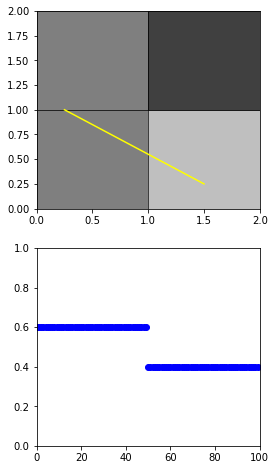

In [105]:
voxels = np.array([[0.5, 0.25], [0.5, 0.75]])

fig = plt.figure(figsize=(2*voxels.shape[0],4*voxels.shape[1]))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax.set_xlim([0, voxels.shape[0]])
ax.set_ylim([0, voxels.shape[1]])
for x in range(voxels.shape[0]):
    for y in range(voxels.shape[1]):
        ax.add_patch(generate_voxel_patch(x, y, voxels[y][x], size=1))
        
from matplotlib import animation, rc
from IPython.display import HTML

FRAMES = 100
ax2.set_xlim([0,FRAMES])
ax2.set_ylim([0,1])
plot, = ax.plot([], [], color="yellow")
def animate(i):
    x0, y0 = 0.25, 1
    x1, y1 = 1.5, 0.25 + i*1.5/FRAMES
    m = (y1-y0)/(x1-x0)
    xv = 1.
    yv = m*(xv-x0) + y0
    plot.set_data([x0, x1], [y0, y1])
    arc_length = np.sqrt((x1-x0)**2 + (y1-y0)**2)
    reach = (1-voxels[int((yv+y0)/2.)][int((xv+x0)/2.)]) * np.sqrt((xv-x0)**2 + (yv-y0)**2)
    reach += (1-voxels[int(y1)][int(x1)]) * np.sqrt((xv-x1)**2 + (yv-y1)**2)
    reach /= arc_length
    ax2.scatter([i], [reach], color="blue")
    return plot

import matplotlib
matplotlib.rcParams['animation.writer'] = 'avconv'
anim = animation.FuncAnimation(fig, animate, 
                               frames=FRAMES, interval=20, blit=False)
HTML(anim.to_html5_video())

## Sampling between voxels using shapes
Instead of bilinear filtering, the sampling points are represented by a shape that sweeps along the trajectory (just like the robot). The amount of area that intersects with the voxel determines the ratio of the voxel's density that contributes to the sampled reachability.

### Box Shape Sampling

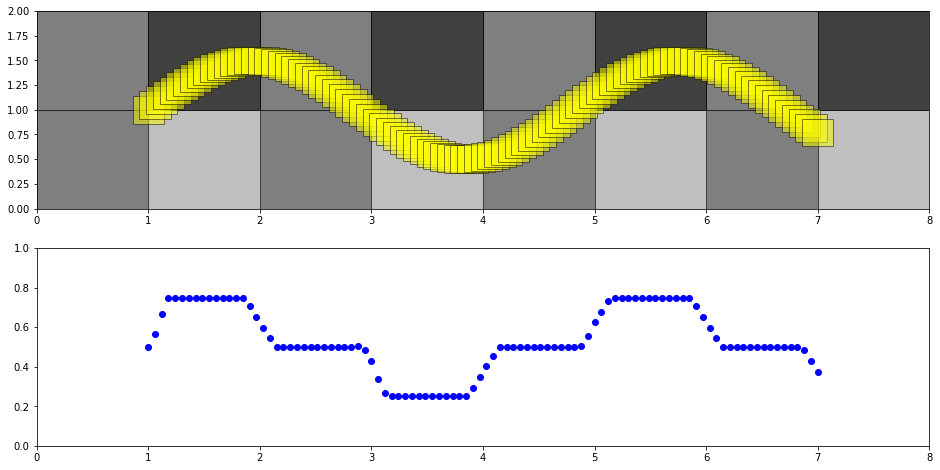

In [229]:
voxels = np.array([[0.5, 0.25]*4, [0.5, 0.75]*4]).T

fig = plt.figure(figsize=(2*voxels.shape[0],4*voxels.shape[1]))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax.set_xlim([0, voxels.shape[0]])
ax.set_ylim([0, voxels.shape[1]])
for x in range(voxels.shape[0]):
    for y in range(voxels.shape[1]):
        ax.add_patch(generate_voxel_patch(x, y, voxels[x][y], size=1))
        

import math

# Area of intersection between circle and rectangle (src: http://stackoverflow.com/a/32698993)

# returns the positive root of intersection of line y = h with circle centered at the origin and radius r
def section(h, r = 1):
    # assume r is positive, leads to some simplifications in the formula below (can factor out r from the square root)
    assert(r >= 0)
    # http://www.wolframalpha.com/input/?i=r+*+sin%28acos%28x+%2F+r%29%29+%3D+h
    return np.sqrt(r ** 2 - h ** 2) if h < r else 0

# indefinite integral of circle segment
def g(x, h, r = 1):
    # http://www.wolframalpha.com/input/?i=r+*+sin%28acos%28x+%2F+r%29%29+-+h
    return .5 * (np.sqrt(1 - x**2 / (r**2)) * x * r + r**2 * math.asin(x / r) - 2 * h * x)

# area of intersection of an infinitely tall box with left edge at x0, right edge at x1, bottom edge at h and top edge at infinity, with circle centered at the origin with radius r
def area4(x0, x1, h, r):
    if x0 > x1:
        # this must be sorted otherwise we get negative area
        x0, x1 = x1, x0
    s = section(h, r)
    # integrate the area
    return g(max(-s, min(s, x1)), h, r) - g(max(-s, min(s, x0)), h, r)

# area of the intersection of a finite box with a circle centered at the origin with radius r
def area_(x0, x1, y0, y1, r):
    if y0 > y1:
        y0, y1 = y1, y0 # this will simplify the reasoning
    if y0 < 0:
        if y1 < 0:
            # the box is completely under, just flip it above and try again
            return area_(x0, x1, -y0, -y1, r)
        else:
            # the box is both above and below, divide it to two boxes and go again
            return area_(x0, x1, 0, -y0, r) + area_(x0, x1, 0, y1, r)
    else:
        # y0 >= 0, which means that y1 >= 0 also (y1 >= y0) because of the swap at the beginning
        assert(y1 >= 0)
        # area of the lower box minus area of the higher box
        return area4(x0, x1, y0, r) - area4(x0, x1, y1, r)

# area of the intersection of a general box with a general circle
def area(x0, x1, y0, y1, cx, cy, r):
    # get rid of the circle center
    x0 -= cx
    x1 -= cx
    y0 -= cy
    y1 -= cy

    return area_(x0, x1, y0, y1, r)

import matplotlib.patches
def box_sample(x, y, box_size=0.7):
    xmin, xmax = 0, voxels.shape[0]
    ymin, ymax = 0, voxels.shape[1]
    voxel_size = 1    
    
    l = max(x-box_size/2, xmin)
    r = min(x+box_size/2, xmax)
    b = max(y-box_size/2, ymin)
    t = min(y+box_size/2, ymax)
    
    ax.add_patch(patches.Rectangle([l, b], width=box_size, height=box_size, facecolor="yellow", alpha=0.5, edgecolor="black"))    
    
    li, ri, bi, ti = int((l - xmin) / voxel_size), int((r - xmin) / voxel_size), \
                     int((b - ymin) / voxel_size), int((t - ymin) / voxel_size)
    mh, mv = ri * voxel_size + xmin, ti * voxel_size + ymin
#     print l, mh, r
#     print b, mv, t
    if li == ri and  bi == ti:
#         print "li == ri and bi == ti", li, bi
        return voxels[li][ti]
    if bi == ti:
#             print "horizontal", mh-l, r-mh
        return ((mh-l)*box_size*voxels[li][ti] + (r-mh)*box_size*voxels[ri][ti]) / (box_size**2)
    if li == ri:
#             print "vertical", mv-b, t-mv
        return ((mv-b)*box_size*voxels[li][bi] + (t-mv)*box_size*voxels[li][ti]) / (box_size**2)

#         print li, ri, bi, ti
    return ( (mv-b)*(mh-l)*voxels[li][bi] + (t-mv)*(mh-l)*voxels[li][ti] \
           + (mv-b)*(r-mh)*voxels[ri][bi] + (t-mv)*(r-mh)*voxels[ri][ti]) / (box_size**2)
        

FRAMES = 100
ax2.set_xlim([0,voxels.shape[0]])
ax2.set_ylim([0,1])
# def animate(i):
for i in range(FRAMES):
    x, y = 6. * i*1./(FRAMES-1) + 1, 1 + math.sin(i*10./FRAMES)/2.
    reach = box_sample(x, y, box_size=0.28)
    ax2.scatter([x], [reach], color="blue")
#     return plot

# import matplotlib
# matplotlib.rcParams['animation.writer'] = 'avconv'
# anim = animation.FuncAnimation(fig, animate, 
#                                frames=FRAMES, interval=20, blit=False)
# HTML(anim.to_html5_video())

### Circle Shape Sampling

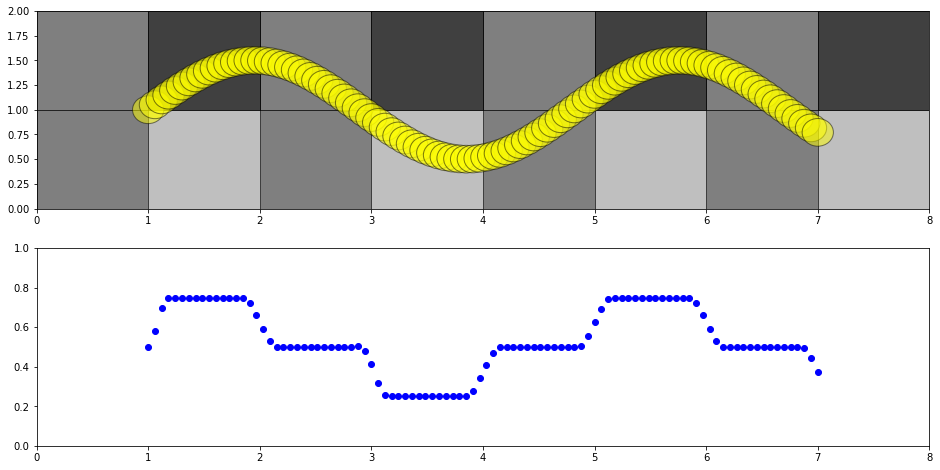

In [211]:
voxels = np.array([[0.5, 0.25]*4, [0.5, 0.75]*4]).T

fig = plt.figure(figsize=(2*voxels.shape[0],4*voxels.shape[1]))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax.set_xlim([0, voxels.shape[0]])
ax.set_ylim([0, voxels.shape[1]])
for x in range(voxels.shape[0]):
    for y in range(voxels.shape[1]):
        ax.add_patch(generate_voxel_patch(x, y, voxels[x][y], size=1))
        

import math

# Area of intersection between circle and rectangle (src: http://stackoverflow.com/a/32698993)

# returns the positive root of intersection of line y = h with circle centered at the origin and radius r
def section(h, r = 1):
    # assume r is positive, leads to some simplifications in the formula below (can factor out r from the square root)
    assert(r >= 0)
    # http://www.wolframalpha.com/input/?i=r+*+sin%28acos%28x+%2F+r%29%29+%3D+h
    return np.sqrt(r ** 2 - h ** 2) if h < r else 0

# indefinite integral of circle segment
def g(x, h, r = 1):
    # http://www.wolframalpha.com/input/?i=r+*+sin%28acos%28x+%2F+r%29%29+-+h
    return .5 * (np.sqrt(1 - x**2 / (r**2)) * x * r + r**2 * math.asin(x / r) - 2 * h * x)

# area of intersection of an infinitely tall box with left edge at x0, right edge at x1, bottom edge at h and top edge at infinity, with circle centered at the origin with radius r
def area4(x0, x1, h, r):
    if x0 > x1:
        # this must be sorted otherwise we get negative area
        x0, x1 = x1, x0
    s = section(h, r)
    # integrate the area
    return g(max(-s, min(s, x1)), h, r) - g(max(-s, min(s, x0)), h, r)

# area of the intersection of a finite box with a circle centered at the origin with radius r
def area_(x0, x1, y0, y1, r):
    if y0 > y1:
        y0, y1 = y1, y0 # this will simplify the reasoning
    if y0 < 0:
        if y1 < 0:
            # the box is completely under, just flip it above and try again
            return area_(x0, x1, -y0, -y1, r)
        else:
            # the box is both above and below, divide it to two boxes and go again
            return area_(x0, x1, 0, -y0, r) + area_(x0, x1, 0, y1, r)
    else:
        # y0 >= 0, which means that y1 >= 0 also (y1 >= y0) because of the swap at the beginning
        assert(y1 >= 0)
        # area of the lower box minus area of the higher box
        return area4(x0, x1, y0, r) - area4(x0, x1, y1, r)

# area of the intersection of a general box with a general circle
def area(x0, x1, y0, y1, cx, cy, r):
    # get rid of the circle center
    x0 -= cx
    x1 -= cx
    y0 -= cy
    y1 -= cy

    return area_(x0, x1, y0, y1, r)

import matplotlib.patches
def sample_circle(ax, x, y, radius=0.7):
    xmin = 0
    ymin = 0
    voxel_size = 1
    
    ax.add_patch(patches.Circle([x, y], radius=radius, facecolor="yellow", alpha=0.5, edgecolor="black"))
    
#     fix_point = radius/np.sqrt(2)
#     ax.scatter([x+fix_point, x+fix_point, x-fix_point, x-fix_point],
#                [y+fix_point, y-fix_point, y+fix_point, y-fix_point], color="red", zorder=3)

    r, l = x + radius, x - radius
    t, b = y + radius, y - radius
    ri, li = min(int((r-xmin)/voxel_size), voxels.shape[0]-1), max(int((l-xmin)/voxel_size), 0) 
    ti, bi = min(int((t-ymin)/voxel_size), voxels.shape[1]-1), max(int((b-ymin)/voxel_size), 0)
    
    mh, mv = ri * voxel_size + xmin, ti * voxel_size + ymin
#     print l, mh, r
#     print b, mv, t
    if li == ri and  bi == ti:
        return voxels[li][ti]
    circle_area = np.pi * radius**2
    if bi == ti:
#             print "horizontal", mh-l, r-mh
        return (area(l, mh, b, t, x, y, radius)*voxels[li][ti] + area(mh, r, b, t, x, y, radius)*voxels[ri][ti]) / circle_area
    if li == ri:
#             print "vertical", mv-b, t-mv
        return (area(l, r, b, mv, x, y, radius)*voxels[li][bi] + area(l, r, mv, t, x, y, radius)*voxels[li][ti]) / circle_area
    
#         print li, ri, bi, ti
    return ( area(l, mh, b, mv, x, y, radius)*voxels[li][bi] + area(l, mh, mv, t, x, y, radius)*voxels[li][ti] \
           + area(mh, r, b, mv, x, y, radius)*voxels[ri][bi] + area(mh, r, mv, t, x, y, radius)*voxels[ri][ti]) / circle_area
    
#     return filter_index(0), filter_index(1)
    
    

FRAMES = 100
ax2.set_xlim([0,voxels.shape[0]])
ax2.set_ylim([0,1])
# def animate(i):
for i in range(FRAMES):
    x, y = 6. * i*1./(FRAMES-1) + 1, 1 + math.sin(i*10./FRAMES)/2.
    reach = sample_circle(ax, x, y, radius=.14)
    ax2.scatter([x], [reach], color="blue")
#     return plot

# import matplotlib
# matplotlib.rcParams['animation.writer'] = 'avconv'
# anim = animation.FuncAnimation(fig, animate, 
#                                frames=FRAMES, interval=20, blit=False)
# HTML(anim.to_html5_video())

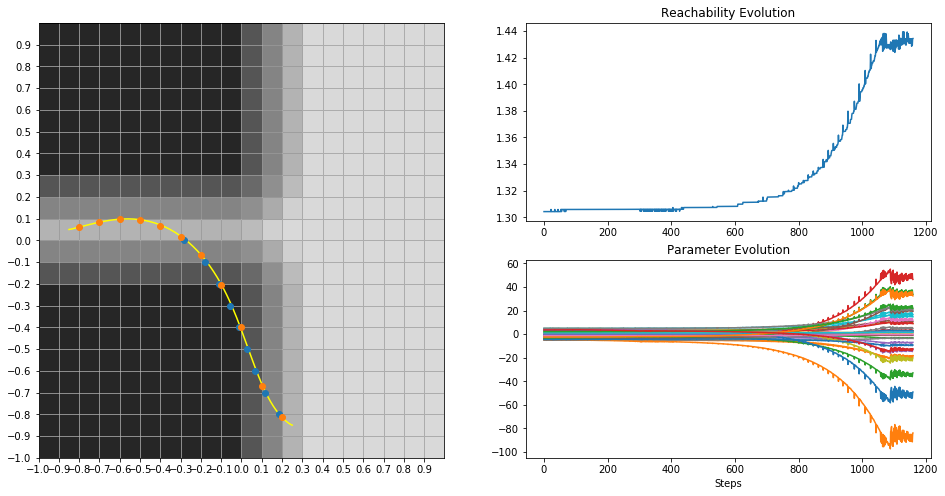

In [38]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Reachability Evolution")
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

_, xs, _ = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, _ = trajectory_curve(sol[1,:].reshape((-1, dd)))

hxvs = []
hyvs = []
vxvs = []
vyvs = []
for x0, y0, x1, y1 in zip(xs, ys, xs[1:], ys[1:]):   
    t0, t1 = x0, x1
    x0 = min(t0, t1)
    x1 = max(t0, t1)
    t0, t1 = y0, y1
    y0 = min(t0, t1)
    y1 = max(t0, t1)
    m = (y1-y0) / (x1-x0)
    xv = int((x1 - xmin) / voxel_size) * voxel_size + xmin
    if x0 <= xv <= x1:
        yv = m*(xv-x0) + y0
        if not xv in vxvs and not yv in vyvs:
            vxvs.append(xv)
            vyvs.append(yv)
    
    yv = int((y1 - ymin) / voxel_size) * voxel_size + ymin
#     print "y0 <= yv <= y1 (%f <= %f <= %f) ? %i" % (y0, yv, y1, y0 <= yv <= y1)
    if y0 <= yv <= y1:
        xv = -(yv-y0)/m + x0
        if not yv in hyvs and not xv in hxvs:
            hxvs.append(xv)
            hyvs.append(yv)

ax.scatter(hxvs, hyvs, zorder=5)
ax.scatter(vxvs, vyvs, zorder=5)
    
ax2.plot(reach_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
#ax.scatter(xdots, ydots, color="yellow", zorder=2)

### "Averaging" reachability weighted by arc length
$$
\begin{align}
R &= \sum_{i} (1-p_i) l_i \\
\text{where}\qquad
l_i &= \mathfrak{L}(f_j) 
\end{align}
$$

In [ ]:
fig = plt.figure(figsize=(16,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[:2, :1])

KAPPA = 1

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("UCB Evolution ($\\kappa=%.1f$)" % KAPPA)
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title("Parameter Evolution")
ax3.set_xlabel("Steps")

plot_world(ax)

param = 10 * (np.random.rand(free.shape[1], 1) - 0.5)
sol = solution + free.dot(param).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="red")
ax.scatter(xdots, ydots, color="red", zorder=2)

param_evolution = []
ucb_evolution = []

def compute_ucb(solution, kappa=KAPPA):
    _, xs, _ = trajectory_curve(solution[0,:].reshape((-1, dd)))
    _, ys, _ = trajectory_curve(solution[1,:].reshape((-1, dd)))

    # draw occupied voxels
    occupied = set()
    reach_left, reach_right, reach = Decimal(1), Decimal(1), 1
    for x, y in zip(xs, ys):        
        mean, std = bilinear_filter(x, y)
        var = Decimal(std) ** Decimal(2)
        mean_sq = Decimal(1.-mean) ** Decimal(2)
        reach_left *= var + mean_sq
        reach_right *= mean_sq        
        reach *= 1. - mean
        
    std_reachability = (reach_left - reach_right).sqrt()
    k = Decimal(kappa)
    ucb = float(Decimal(reach) - std_reachability * k)
    return ucb

def best_ucb(params):
    sol = solution + free.dot(np.array(params)).T
    ucb = compute_ucb(sol)
    ucb_evolution.append(ucb)
    param_evolution.append(params)
    return -ucb  # maximize, i.e. minimize negative UCB

# res = minimize(best_ucb, param, method='Nelder-Mead', options={'xtol': 1e-25, 'disp': True, 'maxiter': 200})
minimizer_kwargs = {"method": "Nelder-Mead"}
# this time, optimization follows the constraints
res = scipy.optimize.basinhopping(best_reachability, param, minimizer_kwargs=minimizer_kwargs, niter=10, stepsize=10, accept_test=valid_trajectory)

ax2.plot(ucb_evolution)
param_evolution = np.array(param_evolution)
for d in range(free.shape[1]):
    ax3.plot(param_evolution[:, d])
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

  status: 1
    nfev: 6800
 success: False
     fun: -0.14898776609427097
       x: array([  5.36418965,  -6.14919266,   1.85530172,   2.36762565,
        -1.73913916,   4.27616476,  -0.56008664,  -0.15773906,
        -1.55971533,  -4.52765074,   1.80980665,  -0.46095086,
        -1.450645  ,  -1.94741182,  -0.15104569,  -0.08008712,
         0.13653032, -14.90611862,  -4.51994054,  -2.44298425,
        -1.4358491 ,  -2.86216019,   2.40421631, -14.68316651,
        -2.21454175,   2.12779352, -14.05383091,  -4.98780452,
        -0.12502916,  -3.87672605,   1.39249828,   3.67517117,
         0.03276381,  -0.15557976])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 4962
Delta t: 0.111111111111
Product integral reachability: 8.12734499275e-08
Voxel-based reachability: 1.20175334956e-11 0.284440063593


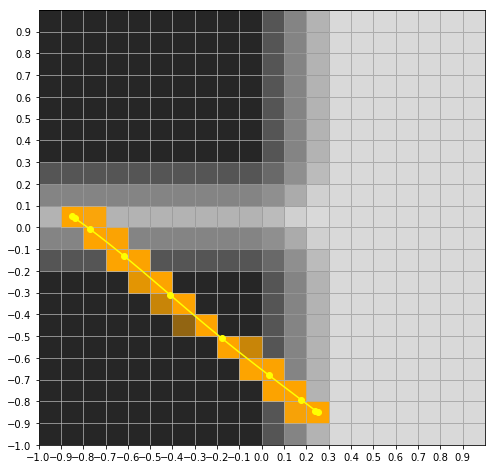

In [53]:
fig = plt.figure(figsize=(8,8))
import matplotlib.gridspec as gridspec
ax = fig.add_subplot(111)

plot_world(ax)
    
print res
r = np.array(res.x)
sol = solution + free.dot(r).T
_, xs, xdots = trajectory_curve(sol[0,:].reshape((-1, dd)))
_, ys, ydots = trajectory_curve(sol[1,:].reshape((-1, dd)))
ax.plot(xs, ys, color="yellow")
ax.scatter(xdots, ydots, color="yellow", zorder=2)

occupied = set()
reach = 1.
delta_t = np.mean(np.diff(times))
print "Delta t:", delta_t
for x, y in zip(xs, ys):
    i = int((x - xmin) / voxel_size)
    j = int((y - ymin) / voxel_size)
    if i < 0 or j < 0 or i >= xdim or j >= ydim:
        continue
    occupied.add((i, j))
    mean, std = bilinear_filter(x, y)
    reach *= (1 - mean) ** delta_t
    
    x = xmin + i * voxel_size
    y = ymin + j * voxel_size
    ax.add_patch(generate_voxel_patch(x, y, 0.5, color="orange"))
    
print "Product integral reachability:", reach

reach = 1.
for (i, j) in occupied:        
    mean, std = world[i][j]     
    reach *= 1. - mean

print "Voxel-based reachability:", reach, reach **(1./len(occupied))

## Product Intergral vs. Discrete Reachability Multiplication
If the sampling points $x(t)$ are positioned at the edges of intersecting voxels, the product integral $\prod_t \left(1-m_{\lfloor x(t)\rfloor}\right)^{\left|\left|x(t)-x(t-\Delta t)\right|\right|_2}$ yields the same reachability as the discrete multiplication of voxel reachabilities $\prod_i(1-m_i)$.

Voxel-based reachability:	0.000014
Interpolated reachability:	0.000014 (std: 0.000000)


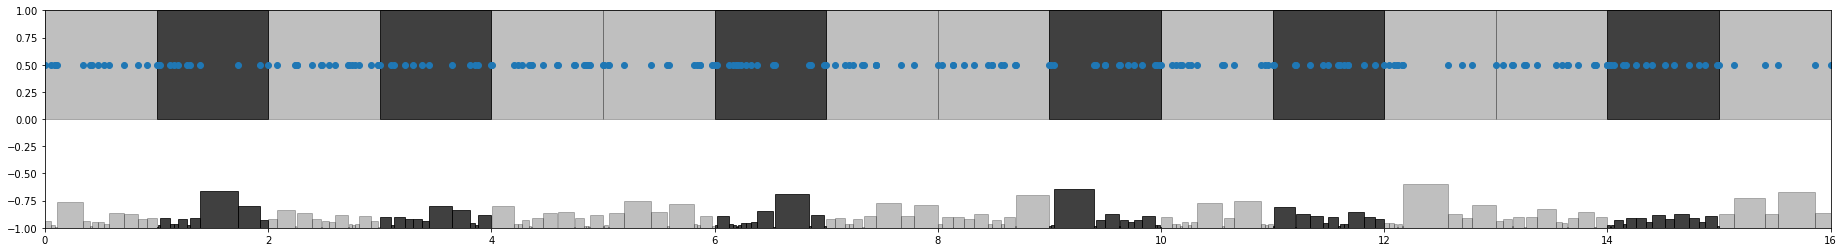

In [238]:
voxels = np.array([0.25, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.25]*2)
print "Voxel-based reachability:\t%.6f" % np.prod([1-m for m in voxels])

fig = plt.figure(figsize=(2*len(voxels),4))
ax = fig.add_subplot(111)

ax.set_xlim([0, len(voxels)])
ax.set_ylim([-1, 1])
for x, mean in enumerate(voxels):
    ax.add_patch(generate_voxel_patch(x, 0, mean, size=1))
    
samples = np.array(sorted(list(np.linspace(0, len(voxels), 20, endpoint=False)) + list(range(len(voxels)+1))))

def multiplicative_sample(i):
    p = voxels[i]
    return np.exp(-p - np.log(1 - p) + p * np.log(1 - p))

def linear_sample(x):
    #return voxels[int(x)]
    x = max(0, x-0.5)
    i = max(0, int(x))
    j = min(len(voxels)-1, i+1)
    alpha = (x - i) #**200# * 1.444# ** 40 #* 1.444
    return alpha * voxels[j] + (1-alpha) * voxels[i]
    return alpha * multiplicative_sample(j) + (1-alpha) * multiplicative_sample(i)

def box_sample(x, box_size=0.7):
    return voxels[int(x)]
    l = max(x-box_size/2, 0)
    r = min(x+box_size/2, len(voxels)-1)
    li = int(l)
    ri = int(r)
    if li == ri:
        return voxels[li]
    return ((ri-l)*box_size*voxels[li] + (r-ri)*box_size*voxels[ri]) / (box_size**2)
    
reaches = []
for k in range(500):
    samples = np.array(sorted(list(np.random.rand(200) * len(voxels)) + list(range(len(voxels)+1))))
    if k == 0:
        ax.scatter(samples, [.5] * len(samples), zorder=2)
    reach = (1 - voxels[0]) ** samples[0]
    delta_t = np.mean(np.diff(samples))
    for x, xp in zip(samples[1:], samples):
        mx = np.mean([x, xp])
        mean = box_sample(mx)
#         if np.isnan((1. - mean) ** (x-xp)):
#             print mean
#         print mean
        if k == 0:
            ax.add_patch(generate_voxel_patch(xp, -1, mean, size=x-xp))
        reach *= (1. - mean) ** (x-xp)
#     reach *= (1 - voxels[-1]) ** (len(voxels)-samples[-1])
    reaches.append(reach)
print "Interpolated reachability:\t%.6f (std: %.6f)" % (np.mean(reaches), np.std(reaches))